# Cell Admixture Tissue Feature Reduction Utilizing Support Vector Regression Recursive Feature Elimination

This notebook is meant to encompass the entire machine learning pipeline, from initial features to selected features.

1. [Import required packages and display version information](#imports-and-version-information) 
2. [Initial feature reduction](#initial-feature-reduction) 
    1. [Load data](#load-data)
        * Initial feature lists
        * CPTAC 
        * HGSOC 
        * Celladmixture tissue data
    2. [Split tissue data into test/train](#split-tissue-data-into-test-and-train-sets)
    3. [Hyperparameter tuning](#hyperparameter-tuning)
    4. [Perform RFE on reduced CPTAC + HGSOC + Protein Candidate features](#perform-rfe)
        * SVM SVR
        * Save model performances
    5. [Choose reduced featuresets](#choose-reduced-featuresets)
        * at least 15 features, lowest test MSE
3. [Validation](#validation)
    1. [CPTAC](#cptac)
        * model results
        * ssGSEA
    2. [N9 HGSOC](#hgsoc)
        * model results
        * ssGSEA

# Imports and Version Information<a id='imports-and-version-information'></a>

In [1]:
# Dataframes, Linear Algebra, Statistics
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.legend_handler import HandlerTuple
from statannotations.Annotator import Annotator
import matplotlib as mpl

# Progress Bar
from tqdm import tqdm

# System
import os
import pickle
import subprocess
import json

# download data
import requests

# more graphing stuff
mpl.rcParams["savefig.dpi"] = 350 # dpi for saving figures
figure_path = 'figures' # folder for figures (will be created if it doesn't exist)
file_format = 'png' # figure file format
if figure_path not in os.listdir(): # if the figure folder filepath doesn't exist, make the folder
    print(f'Making `./{figure_path}`.')
    os.mkdir(figure_path)
else: # else, do nothing
    print(f'`./{figure_path}` already exists.')

font = {'weight' : 'normal',
    'size'   : 15}
mpl.rc('font', **font)

# data folder
data_folder = 'data'

`./figures` already exists.


In [2]:
print('Version information:')
! pip list | grep -E 'pandas|numpy|scipy|matplotlib|seaborn|scikit-learn'

Version information:
matplotlib               3.7.0
matplotlib-inline        0.1.6
numpy                    1.24.2
pandas                   1.5.3
scikit-learn             1.2.1
scipy                    1.10.0
seaborn                  0.11.2


# Initial Feature Reduction<a id='initial-feature-reduction'></a>
2. [Initial feature reduction](#initial-feature-reduction) 
    1. [Load data](#load-data)
        * Initial feature lists
        * CPTAC 
        * HGSOC 
        * Celladmixture tissue data
    2. [Split tissue data into test/train](#split-tissue-data-into-test-and-train-sets)
    3. [Hyperparameter tuning](#hyperparameter-tuning)
    4. [Perform RFE on reduced CPTAC + HGSOC + Protein Candidate features](#perform-rfe)
        * SVM SVR
        * Save model performances
    5. [Choose reduced featuresets](#choose-reduced-featuresets)
        * at least 15 features, lowest test MSE

## Load data<a id='load-data'></a>

### Protein Candidates

In [3]:
tls_strings = ['Tumor', 'Lymphocyte', 'Stroma'] # create a variable holding the cell types as strings for easier looping
tls_colors = {'Tumor':'#E41A1C', 'Lymphocyte':'#FFD700', 'Stroma':'#000080'}

protein_candidates = {} # dictionary to hold the protein candidate lists
for cell_type in tls_strings:
    protein_candidates[cell_type] = pd.read_excel(f'{data_folder}/admixture/protein candidates.xlsx', sheet_name=f'{cell_type} candidates')

# show tumor protein candidates
print('Tumor Protein Candidates:')
protein_candidates['Tumor']

Tumor Protein Candidates:


,Protein Name,UniProt Accession,logFC Tumor vs Lymphocyte,Lymphocyte vs Tumor PValue,Lymphocyte vs Tumor adjPVal,logFC Tumor vs Stroma,Tumor vs Stroma PValue,Tumor vs Stroma adjPVal
0,Quinone oxidoreductase PIG3 OS=Homo sapiens GN...,Q53FA7,2.800981,7.018847e-08,0.000078,0.867527,0.007431,0.034274
1,CD9 antigen OS=Homo sapiens GN=CD9 PE=1 SV=4,P21926,2.896934,9.541974e-08,0.000078,0.932653,0.006787,0.032754
2,Myelin expression factor 2 OS=Homo sapiens GN=...,Q9P2K5,2.637115,9.686144e-08,0.000078,1.178507,0.000595,0.014438
3,"Keratin, type I cytoskeletal 19 OS=Homo sapien...",P08727,2.564098,1.237029e-07,0.000078,0.956128,0.002888,0.022705
4,Podocalyxin OS=Homo sapiens GN=PODXL PE=1 SV=2,O00592,2.440846,1.362357e-07,0.000078,1.109119,0.000651,0.015102
...,...,...,...,...,...,...,...,...
376,Nucleus accumbens-associated protein 1 OS=Homo...,Q96RE7,0.973260,8.721345e-03,0.022814,1.352546,0.000820,0.015797
377,Peroxisomal biogenesis factor 19 OS=Homo sapie...,P40855,0.794911,8.754921e-03,0.022882,1.148949,0.000592,0.014438
378,GMP reductase 1 OS=Homo sapiens GN=GMPR PE=1 SV=1,P36959,0.608042,8.919731e-03,0.023254,0.645651,0.006129,0.031645
379,Regulation of nuclear pre-mRNA domain-containi...,Q96P16,0.815538,9.649872e-03,0.024664,1.248396,0.000413,0.013769


### Tissue Data

In [4]:
admixture_tissue_annotation = pd.read_csv(f'{data_folder}/admixture/CellAdmixture_Tissue_FINAL_imputed_annotated.csv', index_col=1)[['Gene', 'Description', 'seq.text']]
print('Admixture Annotation dataframe shape:', admixture_tissue_annotation.shape)
admixture_tissue_annotation

Admixture Annotation dataframe shape: (6129, 3)


,Gene,Description,seq.text
Accession,,,
A0A075B6R2,IGHV4-4,Immunoglobulin heavy variable 4-4 OS,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...
A0A0B4J1U7,IGHV6-1,Immunoglobulin heavy variable 6-1 OS,MSVSFLIFLPVLGLPWGVLSQVQLQQSGPGLVKPSQTLSLTCAISG...
A0A0B4J2H0,IGHV1-69D,Immunoglobulin heavy variable 1-69D OS,MDWTWRFLFVVAAATGVQSQVQLVQSGAEVKKPGSSVKVSCKASGG...
A0A0C4DH33,IGHV1-24,Immunoglobulin heavy variable 1-24 OS,MDCTWRILFLVAAATGTHAQVQLVQSGAEVKKPGASVKVSCKVSGY...
A0A0C4DH38,IGHV5-51,Immunoglobulin heavy variable 5-51 OS,MGSTAILALLLAVLQGVCAEVQLVQSGAEVKKPGESLKISCKGSGY...
...,...,...,...
Q9Y6X4,FAM169A,Soluble lamin-associated protein of 75 kDa OS,MAFPVDMLENCSHEELENSAEDYMSDLRCGDPENPECFSLLNITIP...
Q9Y6X5,ENPP4,Bis(5'-adenosyl)-triphosphatase ENPP4 OS,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...
Q9Y6X8,ZHX2,Zinc fingers and homeoboxes protein 2 OS,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...


In [5]:
admixture_tissue_log2_imputed_abundances = pd.read_csv(f'{data_folder}/admixture/CellAdmixture_Tissue_FINAL_imputed_annotated.csv', index_col=1).drop(columns=['Gene', 'Description', 'seq.text', 'Unnamed: 0'])
print('Admixture Abundances dataframe shape:', admixture_tissue_log2_imputed_abundances.shape)
admixture_tissue_log2_imputed_abundances

Admixture Abundances dataframe shape: (6129, 16)


,X100Tumor_0Stroma_0Lymphocyte_Other_N.A,X100Tumor_0Stroma_0Lymphocyte_Other_N.A.1,X87.5Tumor_12.5Stroma_0Lymphocyte_Other_N.A,X75Tumor_25Stroma_0Lymphocyte_Other_N.A,X50Tumor_50Stroma_0Lymphocyte_Other_N.A,X25Tumor_75Stroma_0Lymphocyte_Other_N.A,X12.5Tumor_87.5Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A.1,X0Tumor_0Stroma_100Lymphocyte_Other_N.A,X0Tumor_0Stroma_100Lymphocyte_Other_N.A.1,X50Tumor_0Stroma_50Lymphocyte_Other_N.A,X75Tumor_0Stroma_25Lymphocyte_Other_N.A,X87.5Tumor_0Stroma_12.50Lymphocyte_Other_N.A,X93.75Tumor_0Stroma_6.25Lymphocyte_Other_N.A,X96.875Tumor_0Stroma_3.125Lymphocyte_Other_N.A
Accession,,,,,,,,,,,,,,,,
A0A075B6R2,-1.890606,-1.852600,-1.873884,-1.527619,0.438455,1.390362,1.622255,1.683644,1.785914,0.436785,0.174068,-1.100356,-1.599804,-1.950471,-2.132806,-1.926818
A0A0B4J1U7,-1.671173,-1.706672,-1.722978,-1.373352,-0.173502,0.713391,1.167546,1.263856,1.335430,0.316367,0.200550,-1.169045,-1.595031,-1.692603,-1.805017,-1.659710
A0A0B4J2H0,-0.794797,-0.565910,-1.022260,-0.461860,-0.558527,0.217851,0.869275,0.671623,0.604434,-0.195671,0.359855,-0.365296,-0.976721,-0.552087,-0.480925,-1.010301
A0A0C4DH33,-1.307946,-0.734172,-0.803742,-0.923320,-0.520403,-0.004982,0.356822,0.786899,0.653440,-0.868641,-0.007238,-1.401504,-0.705936,-1.066876,-0.661955,-1.147674
A0A0C4DH38,-0.957376,-1.101655,-0.994566,-0.874951,-0.808673,0.750059,0.759421,0.741684,0.892079,0.053522,-0.015513,-0.775692,-0.547729,-0.751310,-0.650199,-0.923626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X4,-0.055016,0.104486,-0.158336,-0.125547,-0.395825,-0.157120,-0.003044,0.026139,-0.173041,0.092770,0.040691,0.078289,-0.121900,-0.012902,0.126927,0.059858
Q9Y6X5,0.389763,0.418267,0.445877,0.416963,0.190632,0.401373,0.261653,-0.353245,-0.090976,0.428713,0.186373,0.080943,0.309839,-0.094064,0.085991,0.224150
Q9Y6X8,-0.085688,-0.173891,-0.277729,-0.267920,-0.300053,-0.350886,-0.318568,-0.372075,-0.403994,0.242270,0.214296,-0.182602,-0.209938,-0.173429,-0.211963,-0.104357


### CPTAC

In [6]:
cptac = pd.read_csv(f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n174_Imputed8242Proteins.txt', sep='\t', index_col=1).drop(columns=['Field1']).T
cptac = cptac.loc[:,cptac.columns.notna()]
cptac.columns.name = None
print('CPTAC dataframe:')
cptac

CPTAC dataframe:


,A2M,ACADM,ACADS,ACADVL,ACAT1,PSEN1,ADA,ADSL,AGA,AGT,...,CHCHD10,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND4,MT-ND5
TCGA-13-1484,-0.68800,0.404000,-0.045000,-0.1470,0.17600,-0.270000,0.83500,0.290000,0.905000,-0.85700,...,0.048889,0.569000,-0.970000,-0.33200,0.228000,0.637000,0.40800,0.58000,-0.04680,1.850000
TCGA-13-1495,0.10900,0.175000,-0.616000,-0.3950,-0.50600,-0.048200,-0.10200,-0.298000,0.200000,-0.49300,...,-0.802000,0.349000,0.457000,0.23600,-0.082800,-0.336000,-0.02480,0.37700,0.03420,-0.053800
TCGA-13-1499,-1.23000,-0.295000,0.108000,-0.1100,-0.46800,0.057425,0.14700,0.235000,-0.224000,-0.82300,...,-0.717000,-0.132000,0.244000,0.10600,0.080400,0.257000,-0.37900,-0.18500,-0.64400,-0.207290
TCGA-13-2071,0.17200,-0.425000,-0.346000,-0.2210,-0.28400,0.032100,-0.01240,-0.265000,0.050300,0.14100,...,0.033400,0.079000,0.134000,-0.16000,0.043800,-0.005370,0.03690,-0.53300,0.03500,0.399000
TCGA-23-1123,-1.27000,0.854000,0.678000,-0.4790,0.99400,-0.413000,0.79400,-0.275000,0.231820,-0.54900,...,0.446000,0.127000,-0.075255,-0.22300,-0.108000,0.105000,0.07510,-0.41100,-0.77400,-0.461000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2008,-0.36055,0.365225,-0.789685,-0.0849,0.21995,-0.139100,-0.19315,-0.181195,-0.220250,1.20948,...,0.745670,0.308452,-0.043750,0.93895,0.091185,0.006814,0.36350,0.66080,-0.35745,-0.095945
TCGA-61-2087,-1.02225,-0.277775,-0.296685,0.4431,1.26795,0.515900,-0.23615,-0.418195,0.158945,-1.37052,...,0.360125,1.078870,1.258250,0.75495,0.821785,0.025814,0.28550,0.87280,1.44755,0.624055
TCGA-61-2088,-1.17225,0.401225,0.529315,0.6991,0.73595,-0.125100,-0.60515,-1.034195,-0.570250,-0.69352,...,0.184034,0.332870,0.202150,0.14385,0.565785,0.114814,0.30250,0.39380,0.17855,0.394055
TCGA-61-2094,-0.13225,0.056225,0.667315,0.3281,0.20295,0.213617,0.39185,0.426805,0.421708,-0.00952,...,0.040189,0.423420,0.610250,-0.17805,0.302785,-0.131186,0.02443,0.36021,0.43155,0.415055


In [7]:
cptac_molecular_subtypes = pd.read_csv(f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n169_MolecularSubtypes.txt', sep='\t', index_col=1)
print('CPTAC Molecular Subtype Data:')
cptac_molecular_subtypes

CPTAC Molecular Subtype Data:


,ID,ProteomicSubtype
Tumor,,
TCGA-09-1664,2,Differentiated
TCGA-13-1404,3,Immunoreactive
TCGA-13-1409,4,Proliferative
TCGA-13-1410,5,Mesenchymal
TCGA-13-1482,6,Mesenchymal
...,...,...
TCGA-61-2088,166,Proliferative
TCGA-61-2094,167,Immunoreactive
TCGA-61-2096,168,Differentiated


#### Get a CPTAC Matrix with Gene Accession Numbers

In [8]:
# make a dictionary to map genes to accession numbers
# accession numbers are genes, but some genes might have the same accession number, as the genes are referring different isoforms of a protein
d = {gene:accession_number for accession_number, gene in zip(admixture_tissue_annotation.index.values.astype(str), admixture_tissue_annotation.Gene.values.astype(str))}
print('Number of genes mapping back to accession numbers:', len(d))
print('There are 3 genes that map to different accession numbers in our tissue admixture data.')

Number of genes mapping back to accession numbers: 6126
There are 3 genes that map to different accession numbers in our tissue admixture data.


In [9]:
print('Tissue Annotation - Same `gene` mapping to different accession numbers!')
admixture_tissue_annotation[admixture_tissue_annotation.Gene.isin(admixture_tissue_annotation[admixture_tissue_annotation.Gene.duplicated()].Gene)]

Tissue Annotation - Same `gene` mapping to different accession numbers!


,Gene,Description,seq.text
Accession,,,
B7ZAP0,RABGAP1L,"Rab GTPase-activating protein 1-like, isoform ...",MIENSSWSMTFEERENRRLQEASMRLEQENDDLAHELVTSKIALRN...
P39880,CUX1,Homeobox protein cut-like 1 OS,MLCVAGARLKRELDATATVLANRQDESEQSRKRLIEQSREFKKNTP...
P42166,TMPO,"Lamina-associated polypeptide 2, isoform alpha OS",MPEFLEDPSVLTKDKLKSELVANNVTLPAGEQRKDVYVQLYLQHLT...
P42167,TMPO,"Lamina-associated polypeptide 2, isoforms beta...",MPEFLEDPSVLTKDKLKSELVANNVTLPAGEQRKDVYVQLYLQHLT...
Q13948,CUX1,Protein CASP OS,MAANVGSMFQYWKRFDLQQLQRELDATATVLANRQDESEQSRKRLI...
Q5R372,RABGAP1L,Rab GTPase-activating protein 1-like OS,MEVRASLQKVSGSSDSVATMNSEEFVLVPQYADDNSTKHEEKPQLK...


In [10]:
cptac_accession_numbers = cptac.copy()
cptac_accession_numbers.columns = [d.get(gene) for gene in cptac_accession_numbers.columns] # for each gene, find the accession number associated (if it exists in the identified proteins) 
cptac_accession_numbers = cptac_accession_numbers.loc[:,cptac_accession_numbers.columns.notna()] # remove NAs, which are introduced when the gene doesn't exist in the admixture tissue identified proteins
cptac_accession_numbers.columns.name = None 
cptac_accession_numbers.index = cptac_accession_numbers.index.astype(str)
# because cptac is labeled by genes, and some accession numbers map to multiple genes, cptac has duplicated gene names as columns, and we have to pick one
cptac_accession_numbers = cptac_accession_numbers.T[~cptac_accession_numbers.columns.duplicated()].T # remove duplicate accession numbers 
print('Dropping duplicates after converting to accession numbers: CPTAC (cptac dataframe) shape -', cptac_accession_numbers.shape)
cptac_accession_numbers

Dropping duplicates after converting to accession numbers: CPTAC (cptac dataframe) shape - (174, 5337)


,P01023,P11310,P16219,P49748,P24752,P49768,P00813,P30566,P01019,P13716,...,P02751,Q13098,Q07002,Q05655,Q6QNY0,Q16512,O76041,Q9H1K1,Q6P4A7,P00403
TCGA-13-1484,-0.68800,0.404000,-0.045000,-0.1470,0.17600,-0.270000,0.83500,0.290000,-0.85700,0.20300,...,-1.0200,-0.228000,-0.385300,0.28600,-0.25900,0.21600,-0.1760,0.017000,-0.06370,0.228000
TCGA-13-1495,0.10900,0.175000,-0.616000,-0.3950,-0.50600,-0.048200,-0.10200,-0.298000,-0.49300,-0.27900,...,1.6100,0.157000,-0.689000,-0.09660,-0.07310,0.33500,0.4050,0.000687,-0.09470,-0.082800
TCGA-13-1499,-1.23000,-0.295000,0.108000,-0.1100,-0.46800,0.057425,0.14700,0.235000,-0.82300,0.09010,...,0.5550,0.190000,-0.103691,-0.09050,-0.16800,0.38200,-0.4340,0.459000,-0.53800,0.080400
TCGA-13-2071,0.17200,-0.425000,-0.346000,-0.2210,-0.28400,0.032100,-0.01240,-0.265000,0.14100,0.23800,...,1.5300,-0.151000,-0.194000,0.06370,0.10000,0.36000,-0.3540,-0.134000,0.17800,0.043800
TCGA-23-1123,-1.27000,0.854000,0.678000,-0.4790,0.99400,-0.413000,0.79400,-0.275000,-0.54900,-0.79400,...,-3.7700,0.105000,0.163000,0.67600,0.12100,-0.07790,0.3620,0.420000,-0.23300,-0.108000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2008,-0.36055,0.365225,-0.789685,-0.0849,0.21995,-0.139100,-0.19315,-0.181195,1.20948,-0.20235,...,-1.0945,0.338695,-0.185450,-0.21795,-0.12875,-0.40425,-0.2144,-0.399450,-0.05805,0.091185
TCGA-61-2087,-1.02225,-0.277775,-0.296685,0.4431,1.26795,0.515900,-0.23615,-0.418195,-1.37052,-0.37435,...,-1.8885,-0.246305,0.219550,-0.19195,-0.33905,0.12975,-0.2904,-0.125850,-0.42105,0.821785
TCGA-61-2088,-1.17225,0.401225,0.529315,0.6991,0.73595,-0.125100,-0.60515,-1.034195,-0.69352,0.03965,...,-1.9085,0.251695,0.650550,0.42105,-0.12525,0.09485,0.2396,0.575550,0.05295,0.565785
TCGA-61-2094,-0.13225,0.056225,0.667315,0.3281,0.20295,0.213617,0.39185,0.426805,-0.00952,-0.29735,...,-1.4095,-0.053305,-0.042370,0.43005,0.14795,0.42375,-0.3674,0.020350,-0.47205,0.302785


In [11]:
# save cptac for ssGSEA
cptac_accession_numbers.T.to_csv(f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n174_Imputed8242Proteins_ACCESSION_NUMBERS.csv')

### n9 HGSOC

In [12]:
# download n9 hgsoc data
# from https://doi.org/10.1016/j.isci.2021.102757
file_name = '1-s2.0-S2589004221007252-mmc8.xlsx'

if file_name not in os.listdir(f'{data_folder}/n9_HGSOC'):
    print(f'Downloading {file_name} from HGSOC paper!')
    request = requests.get(f'https://ars.els-cdn.com/content/image/{file_name}')
    with open(f'{data_folder}/n9_HGSOC/{file_name}', 'wb') as f:
        f.write(request.content)
else:
    print(f'`{file_name}` already downloaded.')

`1-s2.0-S2589004221007252-mmc8.xlsx` already downloaded.


In [13]:
hgsoc_abundance = pd.read_excel(f'{data_folder}/n9_HGSOC/{file_name}', index_col=0).T
hgsoc_abundance.index = ['X' + x for x in hgsoc_abundance.index.str.replace(' ', '_')] # replace all spaces with underscore, and put an X for R
hgsoc_abundance.T.to_csv(f'{data_folder}/n9_HGSOC/N9_HGSOC_abundances.csv')
print('HGSOC abundance dataframe:')
hgsoc_abundance

HGSOC abundance dataframe:


,A0A0B4J1U7,A0A0B4J1X5,A0A0C4DH38,A0AV02,A0AV96,A0AVF1,A0AVT1,A0FGR8,A0MZ66,A0PJZ3,...,Q9BUL5,Q9HBL8,Q9HC62,Q9HCL2,Q9NQC8,Q9UGY1,Q9Y4B4,Q9Y653,P01111,Q9H3Q3
X343WJ_Level_1_Enriched_Tumor_Protein,-1.914957,-1.355773,-0.726857,-0.082505,-0.088875,-0.191718,-0.067780,-0.068098,0.120823,-0.721045,...,-0.202786,0.020236,-0.102002,-0.241697,-0.106771,0.134208,-0.083995,-0.032320,-0.058756,-0.003454
X343WJ_Level_2_Enriched_Tumor_Protein,-1.960949,-1.369659,-0.167639,0.198847,0.155908,-0.126776,-0.265270,-0.114189,0.097103,-0.470564,...,-0.102083,-0.133500,0.040029,-0.130727,0.006815,0.036951,-0.121260,-0.192088,-0.128116,0.138841
X343WJ_Level_3_Enriched_Tumor_Protein,-1.778672,-1.430285,-0.357795,0.049491,0.163434,-0.159899,-0.252290,0.072160,-0.036020,-0.223369,...,-0.100235,-0.211293,-0.055543,-0.187683,-0.039704,0.071431,-0.104440,-0.060027,-0.132772,-0.001158
X343WJ_Level_4_Enriched_Tumor_Protein,-1.954286,-1.455760,-0.536050,-0.137608,0.147436,-0.180535,-0.156664,0.026343,0.149692,-0.747703,...,-0.193232,-0.034743,-0.053061,-0.177769,-0.086659,-0.065479,-0.141371,-0.034022,-0.066629,-0.129654
X343WJ_Level_5_Enriched_Tumor_Protein,-1.503023,-1.215094,-0.884776,-0.224847,-0.041885,-0.182370,-0.217744,0.021969,0.165501,-0.505703,...,-0.137052,-0.019853,-0.069480,-0.120858,-0.004832,0.238727,-0.216902,0.041071,-0.049892,-0.060588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X343VT_Level_1_Whole_Tumor_Protein,1.042231,1.071605,0.327218,-0.225254,-0.425435,0.419181,-0.002598,0.177038,-0.308116,-0.214939,...,-0.394939,0.225722,-0.013343,0.151083,-0.055810,-0.894088,-0.092734,0.520237,0.374225,-0.574883
X343VT_Level_2_Whole_Tumor_Protein,1.233648,0.990829,0.573831,-0.080244,-0.379373,0.427815,-0.115040,0.465452,-0.132265,-0.110653,...,-0.311767,-0.505823,0.029132,0.549166,-0.071704,-1.219641,0.044051,-0.232940,0.404284,0.047728
X343VT_Level_3_Whole_Tumor_Protein,1.010506,0.916107,0.573107,0.006445,0.056997,-0.127698,-0.054112,0.295445,0.135476,-0.044965,...,-0.435822,0.048693,0.006202,0.815519,0.038307,-1.052232,0.034052,-0.220991,0.254728,-0.178779
X343VT_Level_4_Whole_Tumor_Protein,1.266812,1.160402,0.903350,-0.054853,-0.076671,0.511405,-0.114983,0.285489,-0.064959,-0.080080,...,-0.532993,0.210641,-0.083914,0.536224,0.012372,-1.033668,-0.061039,0.379299,0.034860,-0.151146


In [14]:
# extract data from sample names
HGSOC_enriched_type = pd.DataFrame(['_'.join(x[-3:-1]) for x in hgsoc_abundance.index.str.split('_')], index=hgsoc_abundance.index).rename(columns={0:'TissueType'})
print('HGSOC enriched sample type:')
HGSOC_enriched_type

HGSOC enriched sample type:


,TissueType
X343WJ_Level_1_Enriched_Tumor_Protein,Enriched_Tumor
X343WJ_Level_2_Enriched_Tumor_Protein,Enriched_Tumor
X343WJ_Level_3_Enriched_Tumor_Protein,Enriched_Tumor
X343WJ_Level_4_Enriched_Tumor_Protein,Enriched_Tumor
X343WJ_Level_5_Enriched_Tumor_Protein,Enriched_Tumor
...,...
X343VT_Level_1_Whole_Tumor_Protein,Whole_Tumor
X343VT_Level_2_Whole_Tumor_Protein,Whole_Tumor
X343VT_Level_3_Whole_Tumor_Protein,Whole_Tumor
X343VT_Level_4_Whole_Tumor_Protein,Whole_Tumor


### Get Final Dataset (overlaps)

In [15]:
print('Original abundances shape:', admixture_tissue_log2_imputed_abundances.shape)
# hgsoc overlap
admixture_tissue_log2_imputed_abundances_hgsoc_overlap = admixture_tissue_log2_imputed_abundances[admixture_tissue_log2_imputed_abundances.index.isin(hgsoc_abundance.columns.values)]
print('Overlap with n9 HGSOC shape:', admixture_tissue_log2_imputed_abundances_hgsoc_overlap.shape)
# cptac overlap
final_admixture_tissue_log2_imputed_abundances = admixture_tissue_log2_imputed_abundances_hgsoc_overlap[admixture_tissue_log2_imputed_abundances_hgsoc_overlap.index.isin(cptac_accession_numbers.columns.values)]
print('Overlap with n9 HGSOC and CPTAC (final) shape:', final_admixture_tissue_log2_imputed_abundances.shape)
final_admixture_tissue_log2_imputed_abundances

Original abundances shape: (6129, 16)
Overlap with n9 HGSOC shape: (5469, 16)
Overlap with n9 HGSOC and CPTAC (final) shape: (5017, 16)


,X100Tumor_0Stroma_0Lymphocyte_Other_N.A,X100Tumor_0Stroma_0Lymphocyte_Other_N.A.1,X87.5Tumor_12.5Stroma_0Lymphocyte_Other_N.A,X75Tumor_25Stroma_0Lymphocyte_Other_N.A,X50Tumor_50Stroma_0Lymphocyte_Other_N.A,X25Tumor_75Stroma_0Lymphocyte_Other_N.A,X12.5Tumor_87.5Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A.1,X0Tumor_0Stroma_100Lymphocyte_Other_N.A,X0Tumor_0Stroma_100Lymphocyte_Other_N.A.1,X50Tumor_0Stroma_50Lymphocyte_Other_N.A,X75Tumor_0Stroma_25Lymphocyte_Other_N.A,X87.5Tumor_0Stroma_12.50Lymphocyte_Other_N.A,X93.75Tumor_0Stroma_6.25Lymphocyte_Other_N.A,X96.875Tumor_0Stroma_3.125Lymphocyte_Other_N.A
Accession,,,,,,,,,,,,,,,,
A0AV96,0.546032,0.515014,0.206044,0.604429,0.001864,-0.123550,0.141318,-0.163989,-0.348740,-0.487913,-0.555376,-0.006374,0.437088,0.346376,0.428325,0.670955
A0AVF1,0.345844,0.210331,0.014039,0.256379,0.161733,0.087997,0.108117,-0.002177,-0.065266,-0.873549,-0.712699,-0.022342,0.171830,0.332617,0.315634,0.034313
A0AVT1,-0.473523,-0.433369,-0.683570,-0.791457,-0.771162,-0.388595,-0.318267,-0.165256,-0.096064,0.690111,0.528664,-0.188171,-0.283137,-0.363882,-0.533982,-0.455931
A0FGR8,-0.051445,-0.150036,-0.136681,0.034804,-0.162620,-0.090880,0.088171,0.127434,0.108998,0.106580,0.024056,-0.094612,-0.081260,-0.085115,-0.038707,0.007136
A0JNW5,-0.320593,-0.443384,-0.270959,-0.432876,-0.835068,-0.263159,-0.074833,0.034675,-0.249400,0.405824,0.437712,-0.181269,-0.069105,-0.263414,-0.342401,-0.352934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X4,-0.055016,0.104486,-0.158336,-0.125547,-0.395825,-0.157120,-0.003044,0.026139,-0.173041,0.092770,0.040691,0.078289,-0.121900,-0.012902,0.126927,0.059858
Q9Y6X5,0.389763,0.418267,0.445877,0.416963,0.190632,0.401373,0.261653,-0.353245,-0.090976,0.428713,0.186373,0.080943,0.309839,-0.094064,0.085991,0.224150
Q9Y6X8,-0.085688,-0.173891,-0.277729,-0.267920,-0.300053,-0.350886,-0.318568,-0.372075,-0.403994,0.242270,0.214296,-0.182602,-0.209938,-0.173429,-0.211963,-0.104357


## Split Tissue Data Into Test and Train Sets<a id='split-tissue-data-into-test-and-train-sets'></a>

There are 16 samples, so 10 will be used for training, and 6 for testing. Additionally, test/train sets will be decided for each tissue subtype, and will be stratified to a feature generated by the amount of that type of tissue (giving test and train sets similar distribution of tissue %).

### Get features from sample names

In [16]:
# get % tumor, stroma, and lymphocyte cells in a dataframe to be used as the target for ML
# tissue 
o_f_j_cell_percents_t = [(float(tumor[1:-5]), float(stroma[0:-6]), float(lymphocyte[0:-10])) for tumor, stroma, lymphocyte, _, _ in admixture_tissue_log2_imputed_abundances.columns.str.split('_')]
target = pd.DataFrame(columns=admixture_tissue_log2_imputed_abundances.columns)
target = target.T
target['Tumor'] = [x[0]/100 for x in o_f_j_cell_percents_t]
target['Stroma'] = [x[1]/100 for x in o_f_j_cell_percents_t]
target['Lymphocyte'] = [x[2]/100 for x in o_f_j_cell_percents_t]
target = target.T
print('SVR Target:')
target

SVR Target:


,X100Tumor_0Stroma_0Lymphocyte_Other_N.A,X100Tumor_0Stroma_0Lymphocyte_Other_N.A.1,X87.5Tumor_12.5Stroma_0Lymphocyte_Other_N.A,X75Tumor_25Stroma_0Lymphocyte_Other_N.A,X50Tumor_50Stroma_0Lymphocyte_Other_N.A,X25Tumor_75Stroma_0Lymphocyte_Other_N.A,X12.5Tumor_87.5Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A,X0Tumor_100Stroma_0Lymphocyte_Other_N.A.1,X0Tumor_0Stroma_100Lymphocyte_Other_N.A,X0Tumor_0Stroma_100Lymphocyte_Other_N.A.1,X50Tumor_0Stroma_50Lymphocyte_Other_N.A,X75Tumor_0Stroma_25Lymphocyte_Other_N.A,X87.5Tumor_0Stroma_12.50Lymphocyte_Other_N.A,X93.75Tumor_0Stroma_6.25Lymphocyte_Other_N.A,X96.875Tumor_0Stroma_3.125Lymphocyte_Other_N.A
Tumor,1.0,1.0,0.875,0.75,0.5,0.25,0.125,0.0,0.0,0.0,0.0,0.5,0.75,0.875,0.9375,0.96875
Stroma,0.0,0.0,0.125,0.25,0.5,0.75,0.875,1.0,1.0,0.0,0.0,0.0,0.00,0.000,0.0000,0.00000
Lymphocyte,0.0,0.0,0.000,0.00,0.0,0.00,0.000,0.0,0.0,1.0,1.0,0.5,0.25,0.125,0.0625,0.03125


### Create features to stratify to
Creating 3 groups for each feature to try and evenly spread % values between test and train sets.

In [17]:
# create a feature that is 0, 1, or 2 depending on whether the cell type percentage is 0-24%, 25-75%, and 75-100%
target_stratify = pd.DataFrame(columns=admixture_tissue_log2_imputed_abundances.columns)
target_stratify = target_stratify.T

tls_strings = ['Tumor', 'Lymphocyte', 'Stroma']
for tissue_type in tls_strings:
    temp = []
    for tissue_percentage, sample in zip(target.T[tissue_type], target.columns):
        if tissue_percentage < 0.25:
            temp.append(0)
        elif tissue_percentage >= 0.75:
            temp.append(2)
        else:
            temp.append(1)
    target_stratify[tissue_type] = temp

### Create test/train splits for each target
Essentially three separate models will be made. They will eventually be combined to create a predictor.

In [18]:
# create directories to hold test/train data
for tissue_type in tls_strings:
    try:
        os.mkdir(f'{data_folder}/{tissue_type}')
        print(f'Created folder at `{data_folder}/{tissue_type}`')
    except FileExistsError:
        print(f'`{data_folder}/{tissue_type}` already exists.')

`data/Tumor` already exists.
`data/Lymphocyte` already exists.
`data/Stroma` already exists.


In [19]:
print('CPTAC/HGSOC abundance overlap shape:', final_admixture_tissue_log2_imputed_abundances.shape)
for tissue_type in tls_strings:
    print(f'Making train/test for {tissue_type}...')

    # overlap with protein candidates!!!
    final_protein_candidate_data = final_admixture_tissue_log2_imputed_abundances[final_admixture_tissue_log2_imputed_abundances.index.isin(protein_candidates[tissue_type]['UniProt Accession'])]
    print(f'Final CPTAC/HGSOC/{tissue_type} protein candidate abundance overlap shape:', final_protein_candidate_data.shape)

    # get train/test split
    X_train, X_test, y_train, y_test = train_test_split(final_protein_candidate_data.T, target.T[[tissue_type]], test_size=0.33, random_state=42, stratify=target_stratify[[tissue_type]])
    
    # print sizes
    print('X_train shape:', X_train.shape)
    print('X_test shape :', X_test.shape)

    # save them in their respective folders
    print(f'Saving train and test splits in `{data_folder}/{tissue_type}/`')
    datasets = [('X_train', X_train), ('X_test', X_test), ('y_train', y_train), ('y_test', y_test)] 
    for name, data in datasets:
        data.to_csv(f'{data_folder}/{tissue_type}/Tissue_{name}_{tissue_type}.csv')

CPTAC/HGSOC abundance overlap shape: (5017, 16)
Making train/test for Tumor...
Final CPTAC/HGSOC/Tumor protein candidate abundance overlap shape: (318, 16)
X_train shape: (10, 318)
X_test shape : (6, 318)
Saving train and test splits in `data/Tumor/`
Making train/test for Lymphocyte...
Final CPTAC/HGSOC/Lymphocyte protein candidate abundance overlap shape: (436, 16)
X_train shape: (10, 436)
X_test shape : (6, 436)
Saving train and test splits in `data/Lymphocyte/`
Making train/test for Stroma...
Final CPTAC/HGSOC/Stroma protein candidate abundance overlap shape: (270, 16)
X_train shape: (10, 270)
X_test shape : (6, 270)
Saving train and test splits in `data/Stroma/`


In [20]:
# load saved data
data_sections = ['X_train', 'X_test', 'y_train', 'y_test']

data = {}

# read in data in loops 
for tissue_type in tls_strings:
    temp_tissue = {}
    for ml_section in data_sections:
        f = pd.read_csv(f'{data_folder}/{tissue_type}/Tissue_{ml_section}_{tissue_type}.csv', index_col=0)
        temp_tissue[ml_section] = f
    data[tissue_type] = temp_tissue
print('Outer-most keys:')
print(data.keys())
print('Inner keys:')
print(data[tls_strings[0]].keys())

Outer-most keys:
dict_keys(['Tumor', 'Lymphocyte', 'Stroma'])
Inner keys:
dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])


In [21]:
# save data
pickle.dump(data, open(f"{data_folder}/admixture/data.pkl", 'wb'))

## Hyperparameter tuning<a id='hyperparameter-tuning'></a>

Here, I create a parameter grid, and using sklearn's GridSearchCV function, each set of parameters is used to train and test a model 5 times. The parameters that get the best average score end up being the parameters that are used to create the models that will be recursively trained in RFE.

In [22]:
# create parameter grid
svr_parameter_grid = [
    {'kernel': ['linear'], 
    'C': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
    'epsilon': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
]
# the larger epsilon, the more error is allowed within model
# C is multiplied to the regularization 

folds = 5 # 5 fold, each test set will have 2 samples
print('Using a grid search approach to tune hyperparameters for Support Vector Regression')

svr = svm.SVR()
grid_search = GridSearchCV(svr, svr_parameter_grid, n_jobs=-1, cv=folds)

# create dictionary to hold hyperparameters for each tissue type
hyperparameters = {}

for tissue_type in tqdm(tls_strings):
    X_train, y_train = data[tissue_type]['X_train'], np.ravel(data[tissue_type]['y_train'])
    grid_search.fit(X_train, y_train)
    hyperparameters[tissue_type] = grid_search.best_params_

Using a grid search approach to tune hyperparameters for Support Vector Regression


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


In [23]:
print(f'Hyperparameters found by grid search using a {folds} fold Cross-Validation')
hyperparameters

Hyperparameters found by grid search using a 5 fold Cross-Validation


{'Tumor': {'C': 0.1, 'epsilon': 1e-06, 'kernel': 'linear'},
 'Lymphocyte': {'C': 0.01, 'epsilon': 0.1, 'kernel': 'linear'},
 'Stroma': {'C': 0.001, 'epsilon': 0.01, 'kernel': 'linear'}}

In [24]:
# defaults
"""
for tissue_type in tls_strings:
    for argument, value in [('C', 1), ('epsilon', 0.1), ('kernel', 'linear')]:
        hyperparameters[tissue_type][argument] = value
"""
print('Printing hyperparameters that will be used:')
hyperparameters

Printing hyperparameters that will be used:


{'Tumor': {'C': 0.1, 'epsilon': 1e-06, 'kernel': 'linear'},
 'Lymphocyte': {'C': 0.01, 'epsilon': 0.1, 'kernel': 'linear'},
 'Stroma': {'C': 0.001, 'epsilon': 0.01, 'kernel': 'linear'}}

## Perform RFE<a id='perform-rfe'></a>

Recursive Feature Elimination, or RFE, is used here to choose a subset of genes that hold the most predictive power for an support vector regressor (SVR). This can help reduce reduncancies when utilizing tools such as ssGSEA for gene set enrichment analyses.

RFE is performed 3 times, once for each tissue type (stroma, lymphocyte, or tumor). The ranks provided by RFE are then used to re-train models and assess their performance on test data. This is visualized with a scatterplot of the mean squared error (MSE) on the y-axis, and number of features on the x-axis. 

In [25]:
rankings = {}
model_performances = {}
best_models = {}

Performing RFE per Target (['Tumor', 'Lymphocyte', 'Stroma'])
---- Tumor RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 318/318 [00:10<00:00, 29.79it/s]


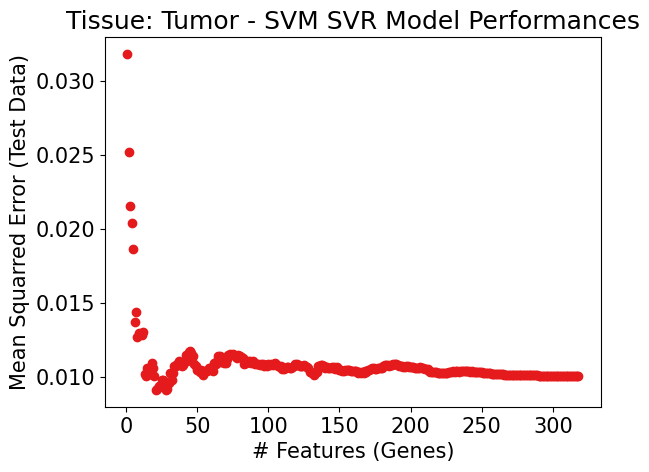

---- Lymphocyte RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 436/436 [00:15<00:00, 27.26it/s]


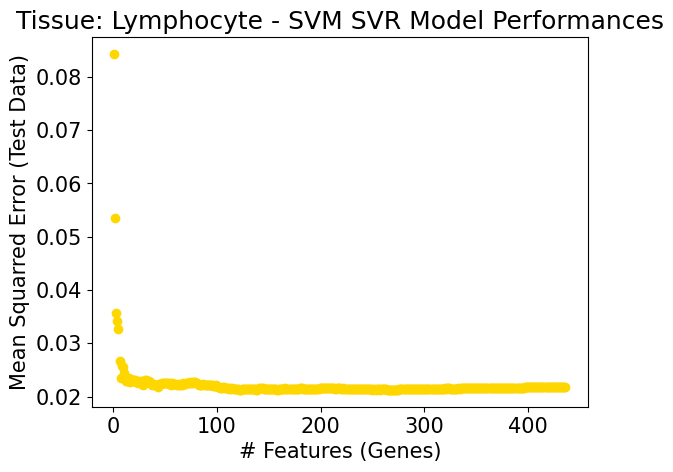

---- Stroma RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 270/270 [00:09<00:00, 28.42it/s]


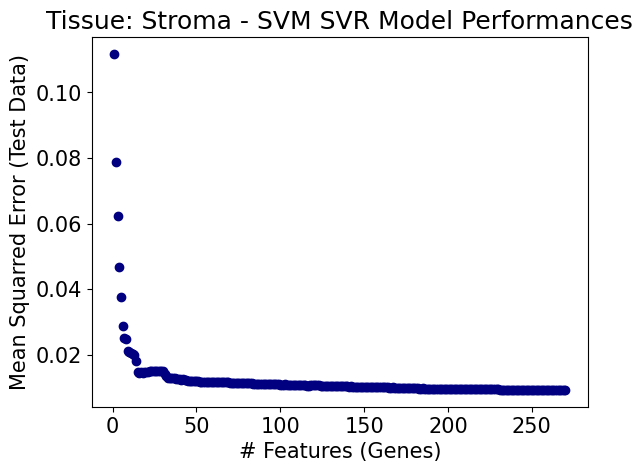

In [26]:
print(f'Performing RFE per Target ({tls_strings})')
for tissue_type in tls_strings:
    print('----', tissue_type, 'RFE ----')
    # define estimator based on hyperparameter tuning
    svr = svm.SVR(**hyperparameters[tissue_type])
    
    # define an RFE
    rfe = RFE(estimator=svr, n_features_to_select=1, step=1, verbose=False)

    # get train data
    X_train, y_train = data[tissue_type]['X_train'], np.ravel(data[tissue_type]['y_train'])

    # fit rfe to get ranking
    rfe.fit(X_train, y_train)
    ranking = rfe.ranking_
    rankings[tissue_type] = ranking

    # get test data
    y_test, X_test = data[tissue_type]['y_test'], data[tissue_type]['X_test']

    # fit all models at different featurelist sizes and plot accuracies
    mse_dict = {}
    models = {}
    min_mse = np.inf
    best_model = None
    print('Train models with each set of features, removing least important ones (by RFE rank):')
    for num_features in tqdm(range(X_train.shape[1], 0, -1)): # for each protein
        rank = pd.Series(ranking, index=X_train.columns).sort_values() # sort by importance rank
        
        # take the top i ranks of training data
        top_num_features = rank.iloc[:num_features]
        top_num_features = X_train[top_num_features.index]

        # fit svr to reduced featurelist training data
        svr.fit(top_num_features, np.ravel(y_train))
        
        # get predictions for reduced features
        y_pred = svr.predict(X_test[top_num_features.columns])
        
        # calculate mean squared error between predictions and actual
        mse = mean_squared_error(y_test, y_pred)

        # get the bets model
        if mse < min_mse:
            min_mse = mse
            best_model = (top_num_features.shape, top_num_features)

        # add to mse dictionary
        mse_dict[num_features] = mse

        # add model to model dictionary
        models[num_features] = (mse, top_num_features)
    pickle.dump(models, open(f'{data_folder}/{tissue_type}/{tissue_type}_model_performances.pkl', 'wb'))

    model_performances[tissue_type] = models

    fig, ax = plt.subplots()
    ax.set_xlabel('# Features (Genes)')
    ax.set_ylabel('Mean Squared Error (Test Data)')
    ax.set_title(f'Tissue: {tissue_type} - SVM SVR Model Performances')
    best_models[tissue_type] = best_model
    plt.scatter(x=mse_dict.keys(), y=mse_dict.values(), color=tls_colors[tissue_type])

    plt.savefig(f'{figure_path}/tissue_{tissue_type}_svm_svr_model_performances.{file_format}', format=file_format)

    plt.show()

In [27]:
# save rankings
pickle.dump(rankings, open(f'{data_folder}/admixture/rankings.pkl', 'wb'))

## Decide on Model for Reduced Featuresets<a id='choose-reduced-featuresets'></a>

To choose a subset of genes for each tissue type, the model with the lowest test MSE with at least 15 features is chosen. The features used in these models will be the reduced featurelists for tools such as ssGSEA. 

Aside: It might be worth looking into choosing models around the 'elbow' of the previous scatterplots. This is where the models don't necessarily have the lowest MSE, but have the fewest features/genes, and could further reduce redundancy while maintaining predictive power.

### Lowest MSE with at least 15 features
This ends up being just the lowest MSE models

In [28]:
min_num_features = 15

In [29]:
tls_features = {}
for tissue_type in tls_strings:
    tissue_specific_model_performances = pd.DataFrame([(x, model_performances[tissue_type][x][0], model_performances[tissue_type][x][1]) for x in model_performances[tissue_type].keys()]).rename(columns={0:'num_features', 1:'mse', 2:'dfs'})
    # sort by MSE
    sorted_model_performances = tissue_specific_model_performances.sort_values(ascending = True, by='mse')
    # remove lower than 15 features, and get the number of features with the lowest MSE
    n_features = sorted_model_performances[sorted_model_performances.num_features >= min_num_features].iloc[0,:].num_features
    this_mse = sorted_model_performances[sorted_model_performances.num_features == n_features].mse.values[0]
    lowest_mse = np.min(tissue_specific_model_performances['mse'])
    print(f'---- {tissue_type} results ----')
    print(f'lowest test MSE of ALL models ---------------------- = {lowest_mse}')
    print(f'lowest test MSE with greater or equal to {min_num_features} features = {this_mse}')
    print(f'all features = {sorted_model_performances.shape[0]}')
    print(f'n features - = {n_features}')
    

    # get the model !
    # define estimator based on hyperparameter tuning
    svr = svm.SVR(**hyperparameters[tissue_type])

    # get train data
    y_train = np.ravel(data[tissue_type]['y_train'])
    X_train = model_performances[tissue_type][n_features][1]
    

    X_train.columns = X_train.columns.astype(str)

    # get test data
    X_test, y_test = data[tissue_type]['X_test'], np.ravel(data[tissue_type]['y_test'])

    # fit svr
    svr.fit(X_train, y_train)

    # predict svr
    y_pred = svr.predict(X_test[X_train.columns])
    assert this_mse == mean_squared_error(y_test, y_pred), 'LOWEST MSES DO NOT MATCH' # check for reproducibility

    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    print(f'Writing pickled object file to `{model_location}`')
    pickle.dump(svr, open(model_location, 'wb'))

    # get features
    tls_features[tissue_type] = list(X_train.columns)

---- Tumor results ----
lowest test MSE of ALL models ---------------------- = 0.009121897240554993
lowest test MSE with greater or equal to 15 features = 0.009121897240554993
all features = 318
n features - = 28
Writing pickled object file to `data/Tumor/Tumor_svr_sklearn_at_least_15_model_cptac_candidate_HGSOC.pkl`
---- Lymphocyte results ----
lowest test MSE of ALL models ---------------------- = 0.021246246138419935
lowest test MSE with greater or equal to 15 features = 0.021246246138419935
all features = 436
n features - = 268
Writing pickled object file to `data/Lymphocyte/Lymphocyte_svr_sklearn_at_least_15_model_cptac_candidate_HGSOC.pkl`
---- Stroma results ----
lowest test MSE of ALL models ---------------------- = 0.00925955279718432
lowest test MSE with greater or equal to 15 features = 0.00925955279718432
all features = 270
n features - = 263
Writing pickled object file to `data/Stroma/Stroma_svr_sklearn_at_least_15_model_cptac_candidate_HGSOC.pkl`


In [30]:
# save json file with features for each model
# serializing
json_object = json.dumps(tls_features, indent=4)

# write file
with open(f'{data_folder}/admixture/tls_gene_sets.json', 'w') as f:
    f.write(json_object)

# Validation<a id='validation'></a>
3. [Validation](#validation)
    1. [CPTAC](#cptac)
        * model results
        * ssGSEA
    2. [N9 HGSOC](#hgsoc)
        * model results
        * ssGSEA

In [31]:
model_type = f'At Least {min_num_features} Features, Lowest MSE'

In [32]:
chosen_models = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    chosen_models[tissue_type] = pickle.load(open(model_location, 'rb'))

### Estimator function
Defined here is the function that takes 3 provided models and outputs a value for each.

Negative model outputs are clipped to 0 (negative values are set to 0), and then the model outputs are each divided by their sum (they all add to 1). This is done so that the model outputs mimic % sample values.

In [33]:
# create a function that takes X as input, and outputs 3 values, normalized from estimators
def run_estimators(X: pd.DataFrame, stroma_model, tumor_model, lymphocyte_model):
    """
    A function that takes normalized abundance values and outputs 3 normalized stroma, tumor, and lymphocyte % tissue scores

    X, stroma_model, tumor_model, lymphocyte_model

    Currently fills in 0 for missing features

    """
    
    # ensure that X has all the required accession numbers
    accession_numbers = np.unique([*stroma_model.feature_names_in_, *tumor_model.feature_names_in_, *lymphocyte_model.feature_names_in_])
    # assert X.columns.isin(accession_numbers).sum() == len(accession_numbers), '`X` does not contain all of the required features!'

    # models
    models = {'Stroma':stroma_model, 'Lymphocyte':lymphocyte_model, 'Tumor':tumor_model}

    # predictions
    predictions = {}

    # make predictions
    for tissue_type in models:
        tX = X.T[X.columns.isin(models[tissue_type].feature_names_in_)].T
        # make missing features 0
        
        missing_features = list(set(models[tissue_type].feature_names_in_) - set(X.columns))
        if missing_features:
            print(f'{tissue_type} has missing features (all values set to 0): {missing_features}')
            print(f'{len(missing_features)/len(models[tissue_type].feature_names_in_) * 100:.2f}% missing for {tissue_type} model...')
            for missing_feature in list(set(models[tissue_type].feature_names_in_) - set(X.columns)):
                tX[missing_feature] = 0
        
        # predict
        tX = tX[models[tissue_type].feature_names_in_]
        tX.columns = tX.columns.astype(str)

        assert (tX.columns == models[tissue_type].feature_names_in_).all() 

        predictions[tissue_type] = models[tissue_type].predict(X=tX)

    # clip values lower than 0 and higher than 1
    predictions_df = np.clip(pd.DataFrame(predictions, index=X.index), 0, 1)

    # make sure values add to 1
    predictions_df = (predictions_df.T/predictions_df.sum(axis=1)).T

    # have a final_prediction value
    predictions_df['prediction'] = predictions_df.idxmax(axis=1)
    
    return predictions_df

## CPTAC<a id='cptac'></a>

Here, I apply both the SVR models created, and ssGSEA methods to a Clinical Proteomic Tumor Analysis Consortium dataset, containing proteomic data from ovarian cancer samples. This serves as an external dataset for validation, with molecular subtypes based on transcriptomics being a surrogate for tissue type. 

In [34]:
validation_name = 'CPTAC'

### Model Outputs

In [35]:
for tissue_type in chosen_models:
    print(f' --- {tissue_type} --- ')
    print(f'Number of features: {len(chosen_models[tissue_type].feature_names_in_)}')

 --- Tumor --- 
Number of features: 28
 --- Lymphocyte --- 
Number of features: 268
 --- Stroma --- 
Number of features: 263


In [36]:
model_outputs = run_estimators(X=cptac_accession_numbers, stroma_model=chosen_models['Stroma'], tumor_model=chosen_models['Tumor'], lymphocyte_model=chosen_models['Lymphocyte'])
model_outputs = model_outputs.merge(cptac_molecular_subtypes, left_index=True, right_index=True)
model_outputs

,Stroma,Lymphocyte,Tumor,prediction,ID,ProteomicSubtype
TCGA-13-1484,0.261696,0.559189,0.179114,Lymphocyte,8,Immunoreactive
TCGA-13-1495,0.372876,0.298565,0.328559,Stroma,15,Mesenchymal
TCGA-13-1499,0.329980,0.397642,0.272377,Lymphocyte,17,Mesenchymal
TCGA-13-2071,0.363515,0.361844,0.274641,Stroma,28,Mesenchymal
TCGA-23-1123,0.096052,0.370395,0.533554,Tumor,31,Immunoreactive
...,...,...,...,...,...,...
TCGA-61-2008,0.280914,0.302631,0.416455,Tumor,164,Differentiated
TCGA-61-2087,0.167460,0.384420,0.448120,Tumor,165,Immunoreactive
TCGA-61-2088,0.180843,0.367442,0.451715,Tumor,166,Proliferative
TCGA-61-2094,0.170414,0.494363,0.335224,Lymphocyte,167,Immunoreactive


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mesenchymal_Lymphocyte vs. Mesenchymal_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:2.289e-01 U_stat=7.470e+02
Differentiated_Tumor vs. Differentiated_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:8.856e-08 U_stat=2.329e+03
Proliferative_Tumor vs. Proliferative_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:3.206e-08 U_stat=5.980e+02
Stromal_Lymphocyte vs. Stromal_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:9.249e-01 U_stat=1.310e+02
Immunoreactive_Tumor vs. Immunoreactive_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:4.893e-01 U_stat=5.640e+02
Immunoreactive_Lymphocyte vs. Immunoreactive_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:6.511e-12 U_stat=1.024e+03
Differentiated_Tumor vs. Differentiated_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.026e-1

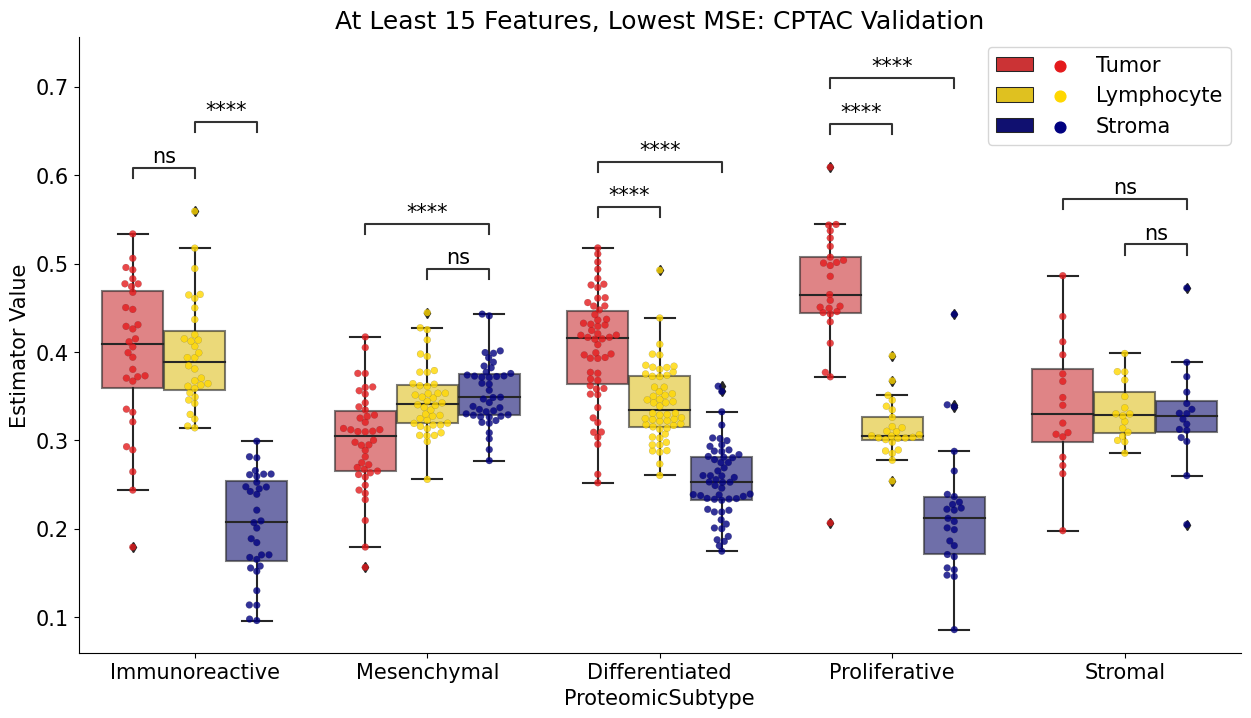

In [37]:
scaffold = pd.DataFrame(columns=model_outputs.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'Estimator Value'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = model_outputs[[x, 'prediction', 'ID', 'ProteomicSubtype']].rename(columns={x:'Estimator Value'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type}: {validation_name} Validation')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
          
pairs = [
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Tumor')),
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Lymphocyte')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Tumor')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Stroma')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Lymphocyte')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Stroma')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Lymphocyte')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Stroma')),
    (('Stromal', 'Stroma'), ('Stromal', 'Lymphocyte')),
    (('Stromal', 'Stroma'), ('Stromal', 'Tumor'))
]
annot = Annotator(ax, pairs, data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

Stroma - not in Immunoreactive v_counts... Putting count of 0
Lymphocyte - not in Proliferative v_counts... Putting count of 0


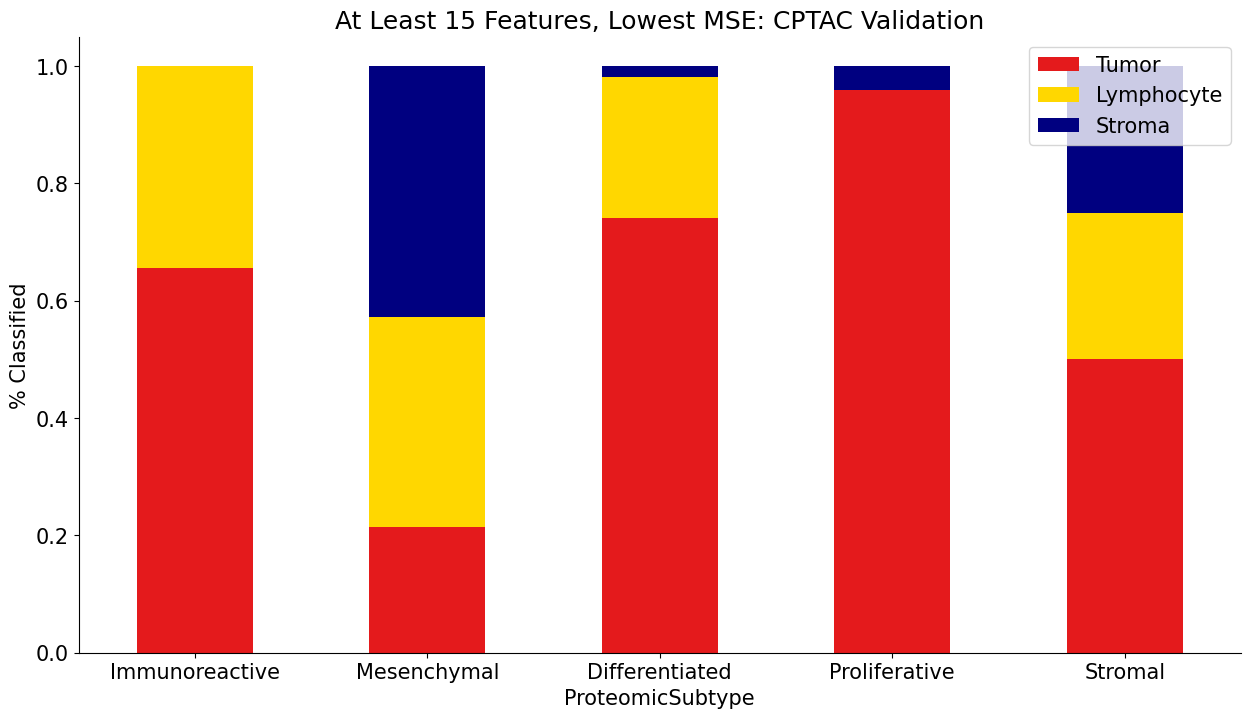

In [38]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in model_outputs.ProteomicSubtype.unique():
    temp = model_outputs[model_outputs.ProteomicSubtype == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'ProteomicSubtype'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type}: CPTAC Validation')
ax.set_xlabel('ProteomicSubtype')
ax.set_ylabel('% Classified')
ax.spines[['right', 'top']].set_visible(False)

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

### ssGSEA

In [39]:
file_names = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    model = pickle.load(open(model_location, 'rb'))
    print(tissue_type, 'Model N features (genes):', len(model.feature_names_in_))

    file_name = f'{data_folder}/{tissue_type}/model_features_{tissue_type}.csv'
    pd.Series(model.feature_names_in_).to_csv(file_name)

    file_names[tissue_type] = file_name

Tumor Model N features (genes): 28
Lymphocyte Model N features (genes): 268
Stroma Model N features (genes): 263


In [40]:
# expression file (Admixture)
expression_file = f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n174_Imputed8242Proteins_ACCESSION_NUMBERS.csv'
output_file_name = 'ssGSEA_cptac'

output_directory = f'{data_folder}/ssGSEA'
try:
    os.mkdir(output_directory)
except FileExistsError:
    print(output_directory, 'already exists...')


# run GSEA R script
process = subprocess.run(['Rscript', 'GSEA.r', expression_file, output_directory, output_file_name, file_names['Lymphocyte'], file_names['Stroma'], file_names['Tumor']])
process.check_returncode() # errors if there is a non-zero exit status

data/ssGSEA already exists...
[1] "Gene set `Lymphocyte` - 268 genes ..."
[1] "Gene set `Stroma` - 263 genes ..."
[1] "Gene set `Tumor` - 28 genes ..."
[1] "Reading in expression file: `data/CPTAC/020323_CPTAC_Ovarian_n174_Imputed8242Proteins_ACCESSION_NUMBERS.csv` ..."
Estimating ssGSEA scores for 3 gene sets.
  |                                                                      |   0%Using parallel with 32 cores
  |======================================================================| 100%


In [41]:
subtype = pd.read_csv(f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n169_MolecularSubtypes.txt', sep='\t', index_col=1).drop(columns=['ID'])
#subtype.index = subtype.index.str.replace('-', '.')

# get colors for types
subtype_colors_dict = dict(zip(subtype.ProteomicSubtype.unique(), sns.color_palette('hls', len(subtype.ProteomicSubtype.unique()))))
subtype_colors = subtype.ProteomicSubtype.map(subtype_colors_dict)

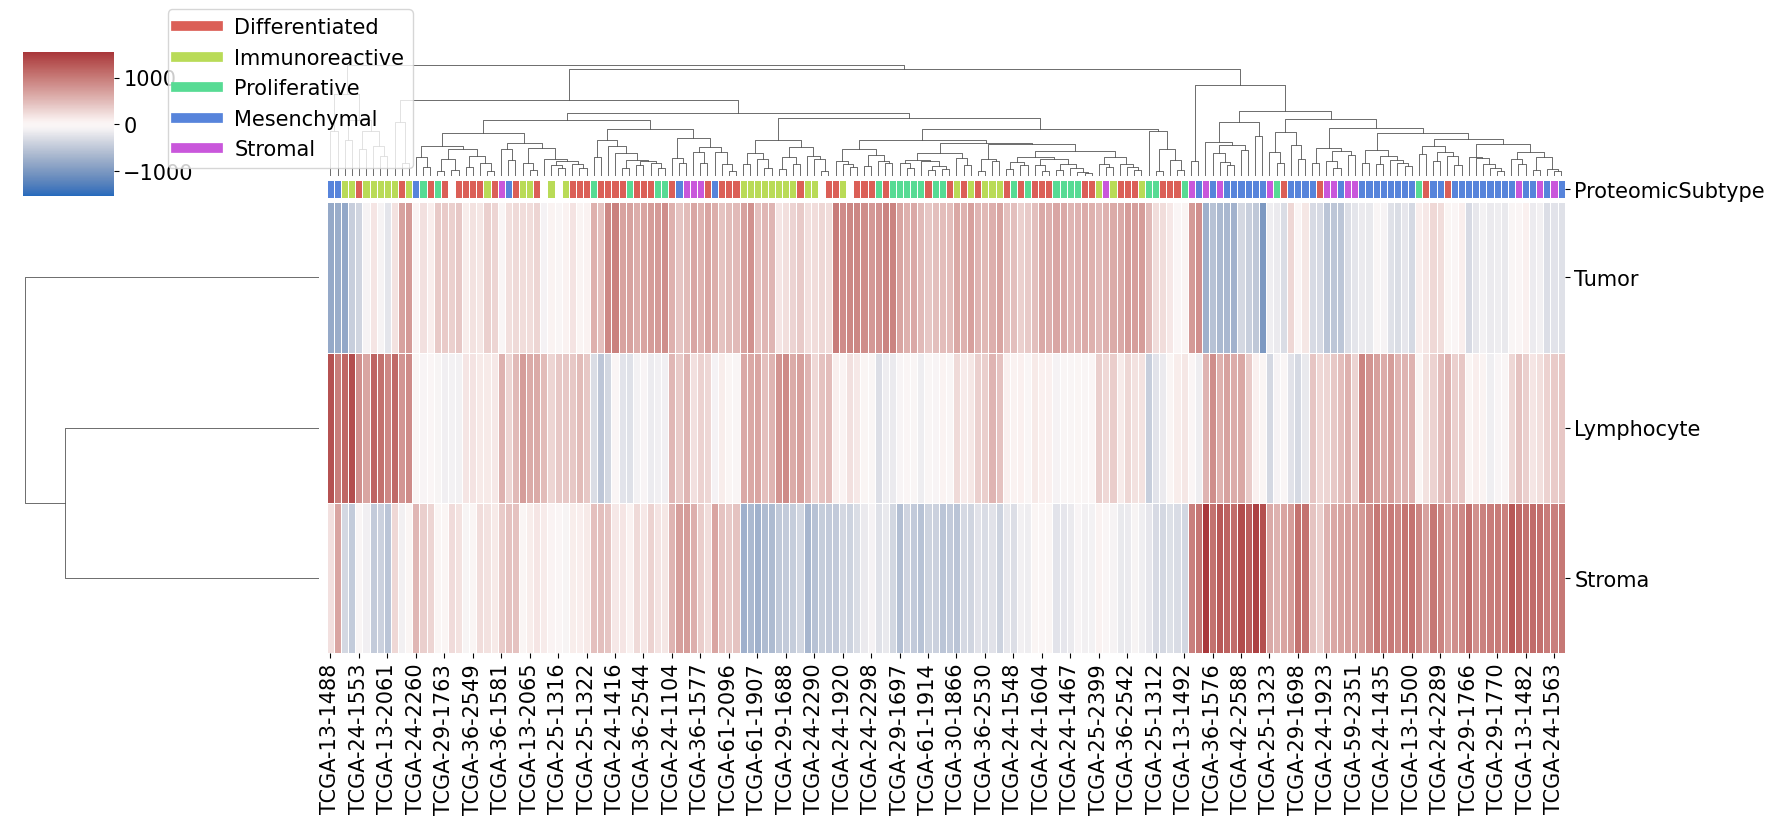

In [42]:
ssGSEA = pd.read_csv(f'{data_folder}/ssGSEA/{output_file_name}.csv', index_col=0)

ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['ProteomicSubtype'] = subtype.ProteomicSubtype

absolute_max_ssGSEA = max(abs(ssGSEA.min().min()), abs(ssGSEA.max().max()))

# change dpi ..?
# plt.rcParams['figure.dpi'] = 200
g = sns.clustermap(data = ssGSEA, cmap='vlag', linewidth=.5, col_colors=subtype_colors, figsize=(18, 8), vmin=-absolute_max_ssGSEA, vmax=absolute_max_ssGSEA)
# custom legend
legend_elements = [Line2D([0], [0], lw=7, color=subtype_colors_dict[x], label=x) for x in subtype_colors_dict]
plt.legend(handles=legend_elements, loc=(1.6, 0.2))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_dendro_heatmap.{file_format}', format=file_format)

plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mesenchymal_Lymphocyte vs. Mesenchymal_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:9.641e-11 U_stat=1.580e+02
Differentiated_Tumor vs. Differentiated_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:1.524e-06 U_stat=2.241e+03
Proliferative_Tumor vs. Proliferative_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:2.297e-08 U_stat=6.010e+02
Stromal_Lymphocyte vs. Stromal_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:4.252e-04 U_stat=3.400e+01
Immunoreactive_Tumor vs. Immunoreactive_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:1.095e-02 U_stat=3.220e+02
Immunoreactive_Lymphocyte vs. Immunoreactive_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.989e-11 U_stat=1.012e+03
Differentiated_Tumor vs. Differentiated_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:6.083e-0

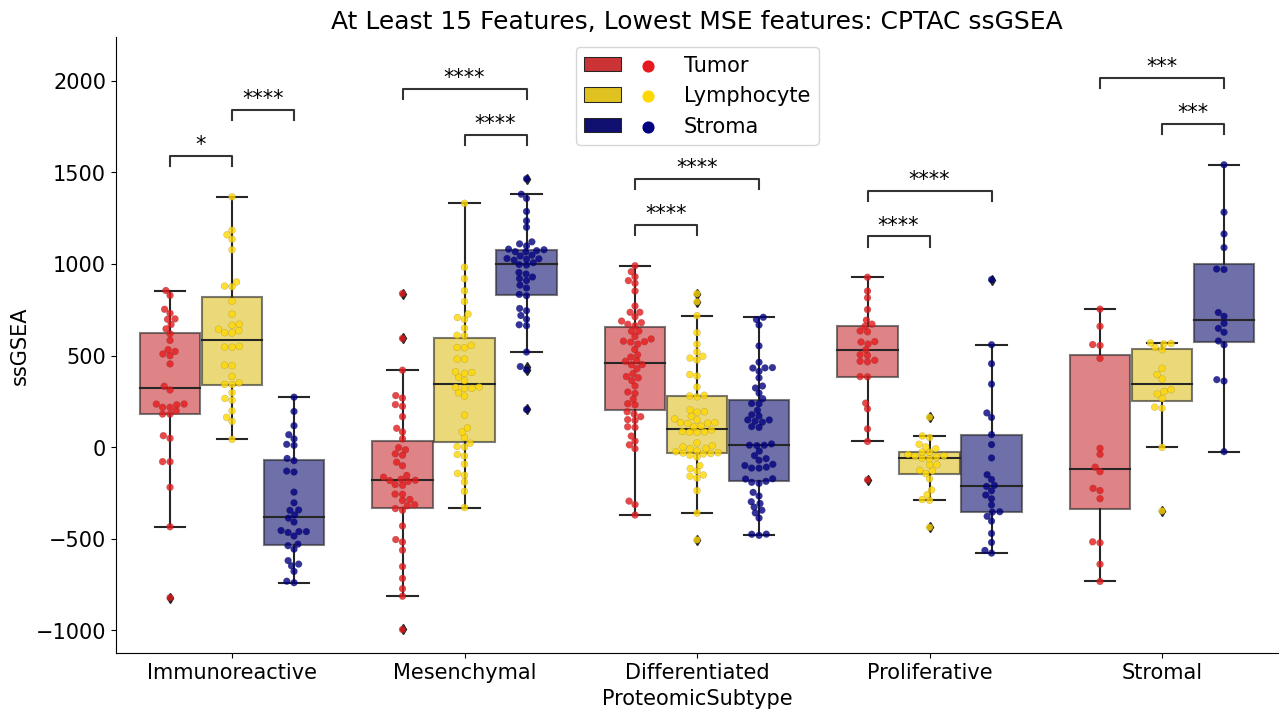

In [43]:
ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['ProteomicSubtype'] = cptac_molecular_subtypes['ProteomicSubtype']

scaffold = pd.DataFrame(columns=ssGSEAt.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'ssGSEA'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = ssGSEAt[[x, 'ProteomicSubtype', 'prediction']].rename(columns={x:'ssGSEA'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type} features: CPTAC ssGSEA')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='upper center', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})


pairs = [
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Tumor')),
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Lymphocyte')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Tumor')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Stroma')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Lymphocyte')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Stroma')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Lymphocyte')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Stroma')),
    (('Stromal', 'Stroma'), ('Stromal', 'Lymphocyte')),
    (('Stromal', 'Stroma'), ('Stromal', 'Tumor'))
]
annot = Annotator(ax, pairs, data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

Stroma - not in Immunoreactive v_counts... Putting count of 0
Tumor - not in Mesenchymal v_counts... Putting count of 0
Stroma - not in nan v_counts... Putting count of 0


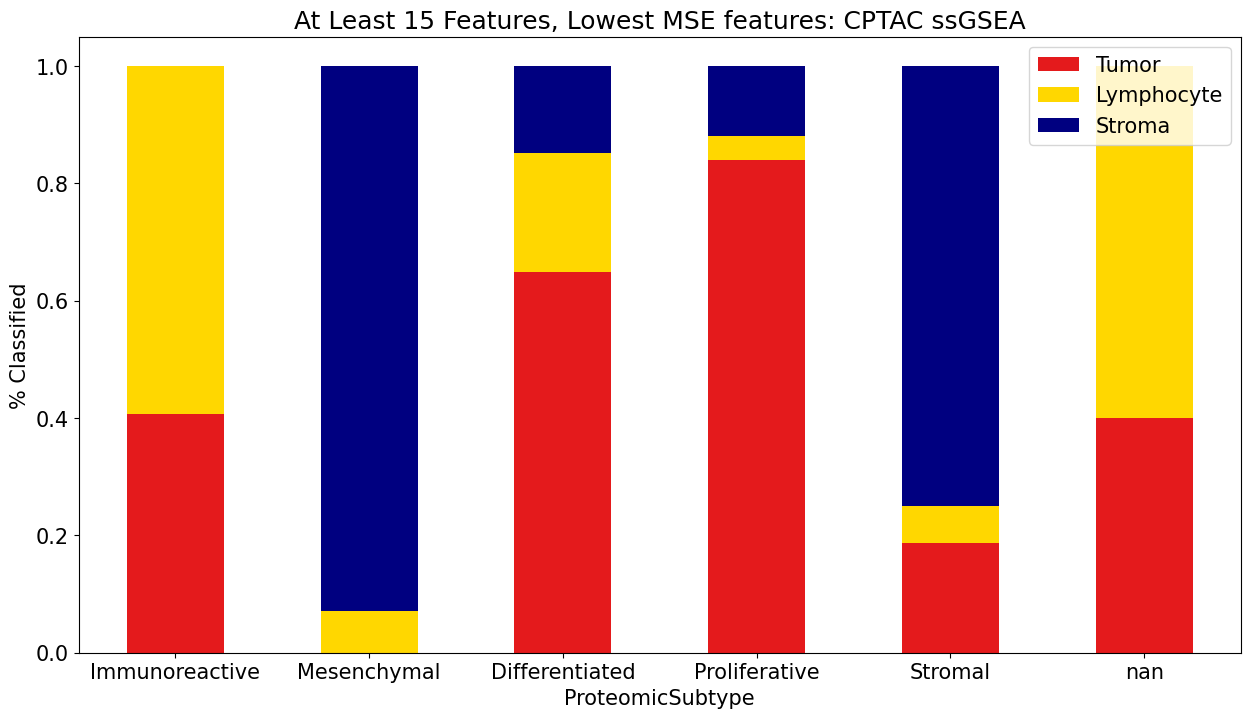

In [44]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in ssGSEAt.ProteomicSubtype.unique():
    if str(subtype) == 'nan':
        temp = ssGSEAt[ssGSEAt.ProteomicSubtype.isna()]
    else:
        temp = ssGSEAt[ssGSEAt.ProteomicSubtype == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'ProteomicSubtype'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type} features: CPTAC ssGSEA')
ax.set_xlabel('ProteomicSubtype')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

## N9 HGSOC<a id='hgsoc'></a>

Here, I apply both the SVR models created, and ssGSEA methods to an [HGSOC dataset](https://www.sciencedirect.com/science/article/pii/S2589004221007252), containing proteomic data from ovarian cancer samples. This serves as an internal dataset for validation, with enriched tissue type being a surrogate for tissue type. 

In [45]:
validation_name = 'HGSOC'

### Model Outputs

In [46]:
for tissue_type in chosen_models:
    print(f' --- {tissue_type} --- ')
    print(f'Number of features: {len(chosen_models[tissue_type].feature_names_in_)}')

 --- Tumor --- 
Number of features: 28
 --- Lymphocyte --- 
Number of features: 268
 --- Stroma --- 
Number of features: 263


In [47]:
model_outputs = run_estimators(X=hgsoc_abundance, stroma_model=chosen_models['Stroma'], tumor_model=chosen_models['Tumor'], lymphocyte_model=chosen_models['Lymphocyte'])
model_outputs = model_outputs.merge(HGSOC_enriched_type, left_index=True, right_index=True)
model_outputs

,Stroma,Lymphocyte,Tumor,prediction,TissueType
X343WJ_Level_1_Enriched_Tumor_Protein,0.000000,0.432635,0.567365,Tumor,Enriched_Tumor
X343WJ_Level_2_Enriched_Tumor_Protein,0.000000,0.360153,0.639847,Tumor,Enriched_Tumor
X343WJ_Level_3_Enriched_Tumor_Protein,0.000000,0.399745,0.600255,Tumor,Enriched_Tumor
X343WJ_Level_4_Enriched_Tumor_Protein,0.000000,0.387399,0.612601,Tumor,Enriched_Tumor
X343WJ_Level_5_Enriched_Tumor_Protein,0.000000,0.387938,0.612062,Tumor,Enriched_Tumor
...,...,...,...,...,...
X343VT_Level_1_Whole_Tumor_Protein,0.471847,0.402808,0.125345,Stroma,Whole_Tumor
X343VT_Level_2_Whole_Tumor_Protein,0.511780,0.381192,0.107028,Stroma,Whole_Tumor
X343VT_Level_3_Whole_Tumor_Protein,0.461340,0.394270,0.144390,Stroma,Whole_Tumor
X343VT_Level_4_Whole_Tumor_Protein,0.427432,0.397986,0.174581,Stroma,Whole_Tumor


/home/schaafj/miniconda3/envs/rfe/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Enriched_Stroma_Lymphocyte vs. Enriched_Stroma_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.976e-12 U_stat=3.000e+00
Whole_Tumor_Tumor vs. Whole_Tumor_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-01 U_stat=9.430e+02
Whole_Tumor_Lymphocyte vs. Whole_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-03 U_stat=1.407e+03
Enriched_Tumor_Tumor vs. Enriched_Tumor_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:3.174e-16 U_stat=2.025e+03
Whole_Tumor_Tumor vs. Whole_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:4.173e-03 U_stat=1.368e+03
Enriched_Stroma_Tumor vs. Enriched_Stroma_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.020e-12 U_stat=0.000e+00
Enriched_Tumor_Tumor vs. Enriched_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.378e-16

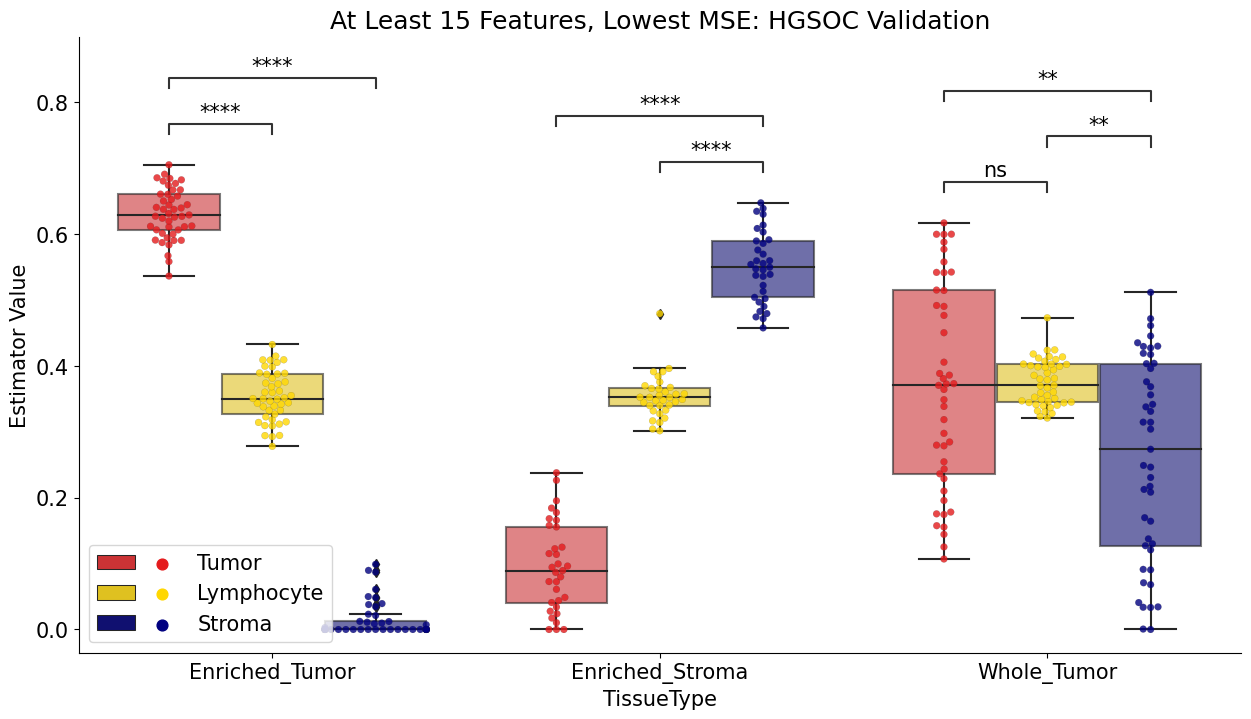

In [48]:
# create dataframe scaffold for figure
scaffold = pd.DataFrame(columns=model_outputs.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'Estimator Value'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = model_outputs[[x, 'prediction', 'TissueType']].rename(columns={x:'Estimator Value'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

# plot the figure
plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type}: HGSOC Validation')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='lower left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

pairs = [
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Stroma')),
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Lymphocyte')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Tumor')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Lymphocyte')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Stroma')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Lymphocyte')),
    (('Whole_Tumor', 'Stroma'), ('Whole_Tumor', 'Lymphocyte'))
]
annot = Annotator(ax, pairs, data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

Lymphocyte - not in Enriched_Tumor v_counts... Putting count of 0
Stroma - not in Enriched_Tumor v_counts... Putting count of 0
Tumor - not in Enriched_Stroma v_counts... Putting count of 0
Lymphocyte - not in Enriched_Stroma v_counts... Putting count of 0


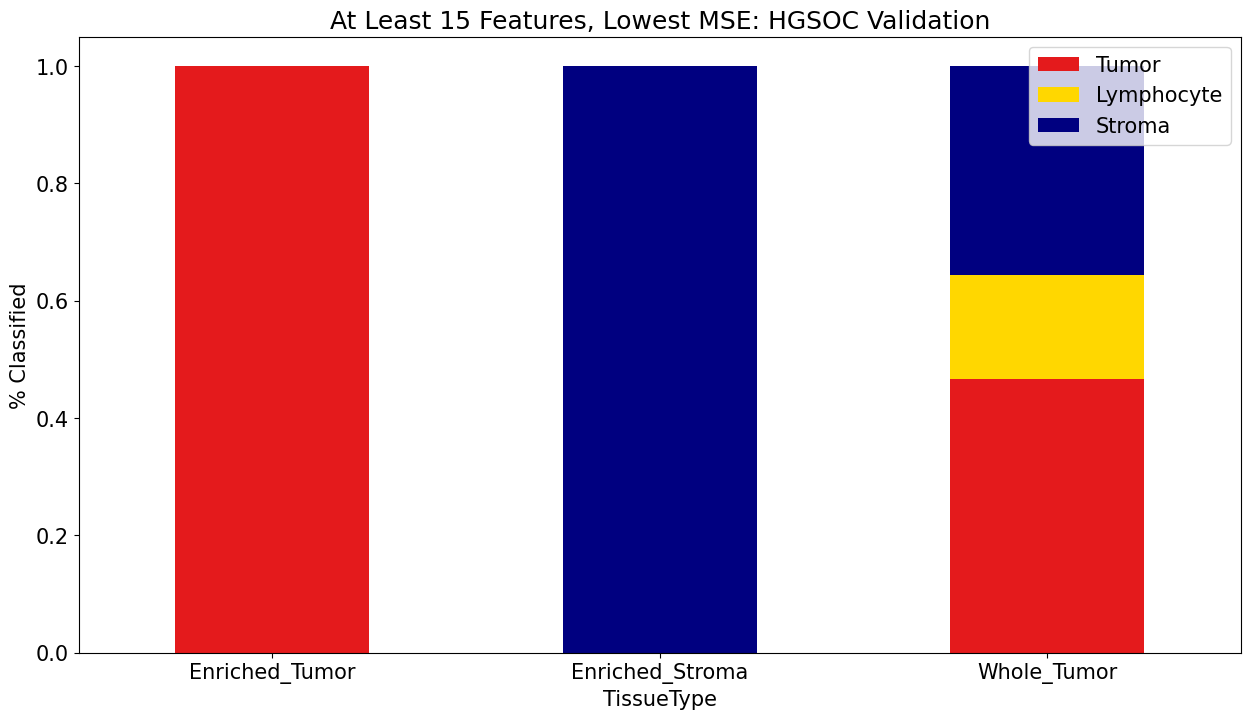

In [49]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in model_outputs.TissueType.unique():
    temp = model_outputs[model_outputs.TissueType == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'TissueType'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type}: HGSOC Validation')
ax.set_xlabel('TissueType')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

### ssGSEA

In [50]:
file_names = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    model = pickle.load(open(model_location, 'rb'))
    print(tissue_type, 'Model N features (genes):', len(model.feature_names_in_))

    file_name = f'{data_folder}/{tissue_type}/model_features_{tissue_type}.csv'
    pd.Series(model.feature_names_in_).to_csv(file_name)

    file_names[tissue_type] = file_name

Tumor Model N features (genes): 28
Lymphocyte Model N features (genes): 268
Stroma Model N features (genes): 263


In [51]:
# expression file (Admixture)
expression_file = f'{data_folder}/n9_HGSOC/N9_HGSOC_abundances.csv'
output_file_name = 'ssGSEA_hgsoc'

output_directory = f'{data_folder}/ssGSEA'
try:
    os.mkdir(output_directory)
except FileExistsError:
    print(output_directory, 'already exists...')


# run GSEA R script
process = subprocess.run(['Rscript', 'GSEA.r', expression_file, output_directory, output_file_name, file_names['Lymphocyte'], file_names['Stroma'], file_names['Tumor']])
process.check_returncode() # errors if there is a non-zero exit status

data/ssGSEA already exists...
[1] "Gene set `Lymphocyte` - 268 genes ..."
[1] "Gene set `Stroma` - 263 genes ..."
[1] "Gene set `Tumor` - 28 genes ..."
[1] "Reading in expression file: `data/n9_HGSOC/N9_HGSOC_abundances.csv` ..."
Estimating ssGSEA scores for 3 gene sets.
  |                                                                      |   0%Using parallel with 32 cores
  |======================================================================| 100%


In [52]:
# get colors for types
subtype_colors_dict = dict(zip(HGSOC_enriched_type.TissueType.unique(), sns.color_palette('hls', len(HGSOC_enriched_type.TissueType.unique()))))
subtype_colors = HGSOC_enriched_type.TissueType.map(subtype_colors_dict)

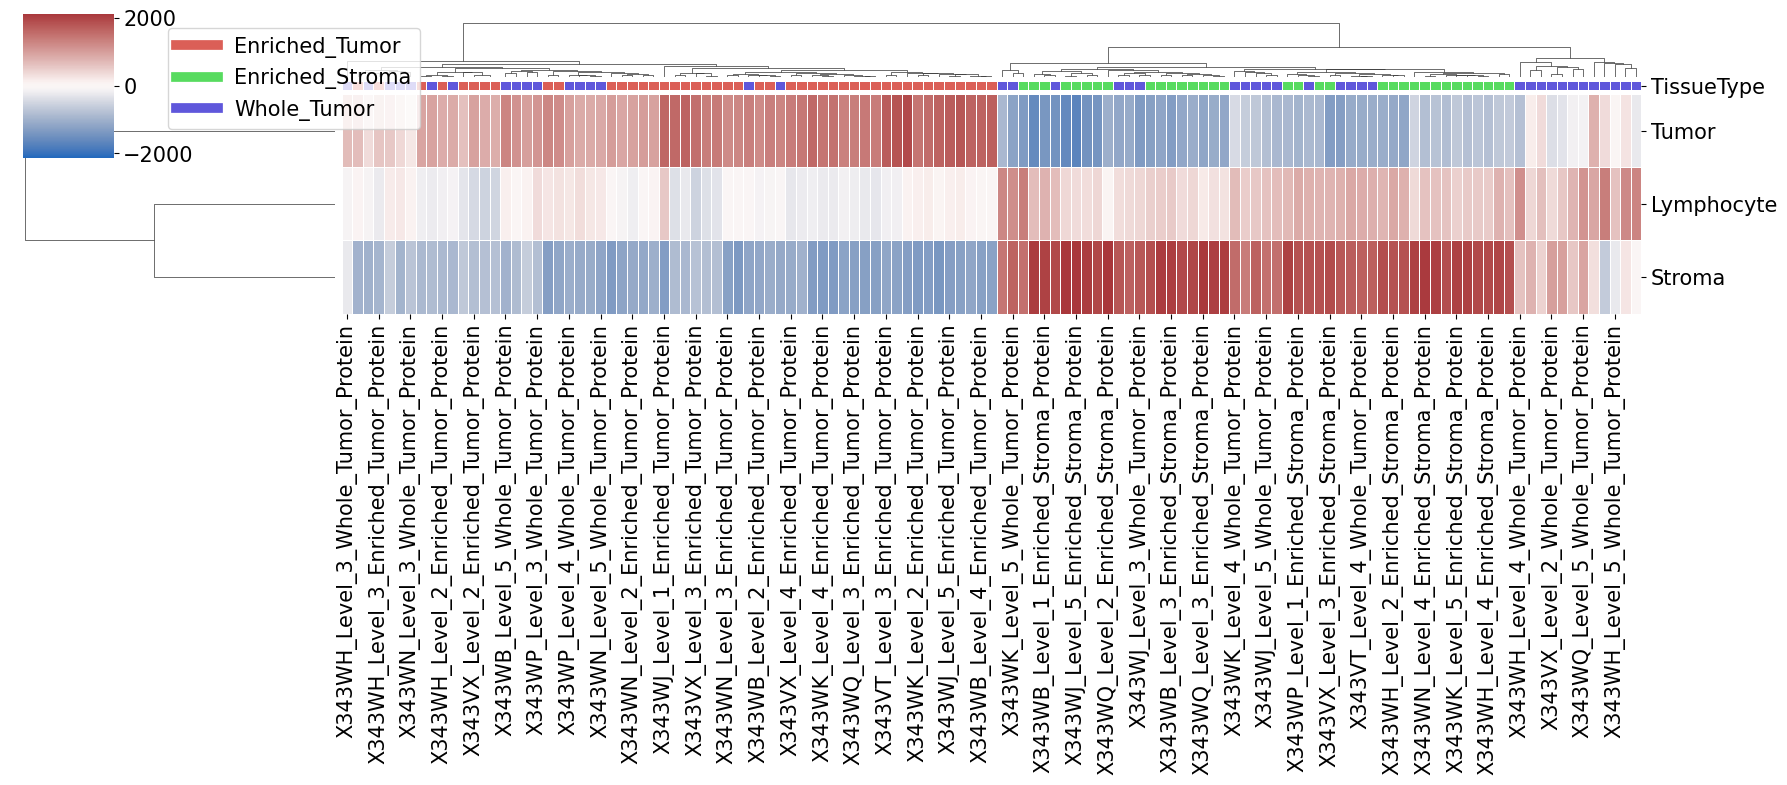

In [53]:
ssGSEA = pd.read_csv(f'{data_folder}/ssGSEA/{output_file_name}.csv', index_col=0)

absolute_max_ssGSEA = max(abs(ssGSEA.min().min()), abs(ssGSEA.max().max()))

# change dpi ..?
# plt.rcParams['figure.dpi'] = 200
g = sns.clustermap(data = ssGSEA, cmap='vlag', linewidth=.5, col_colors=subtype_colors, figsize=(18, 8), vmin=-absolute_max_ssGSEA, vmax=absolute_max_ssGSEA)
# custom legend
legend_elements = [Line2D([0], [0], lw=7, color=subtype_colors_dict[x], label=x) for x in subtype_colors_dict]
plt.legend(handles=legend_elements, loc=(1.6, 0.2))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_dendro_heatmap.{file_format}', format=file_format)

plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Enriched_Stroma_Lymphocyte vs. Enriched_Stroma_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.026e-12 U_stat=0.000e+00
Whole_Tumor_Tumor vs. Whole_Tumor_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:6.226e-03 U_stat=6.730e+02
Whole_Tumor_Lymphocyte vs. Whole_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:7.530e-01 U_stat=1.052e+03
Enriched_Tumor_Tumor vs. Enriched_Tumor_Lymphocyte: Mann-Whitney-Wilcoxon test two-sided, P_val:3.174e-16 U_stat=2.025e+03
Whole_Tumor_Tumor vs. Whole_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:6.942e-02 U_stat=7.870e+02
Enriched_Stroma_Tumor vs. Enriched_Stroma_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.026e-12 U_stat=0.000e+00
Enriched_Tumor_Tumor vs. Enriched_Tumor_Stroma: Mann-Whitney-Wilcoxon test two-sided, P_val:3.174e-16

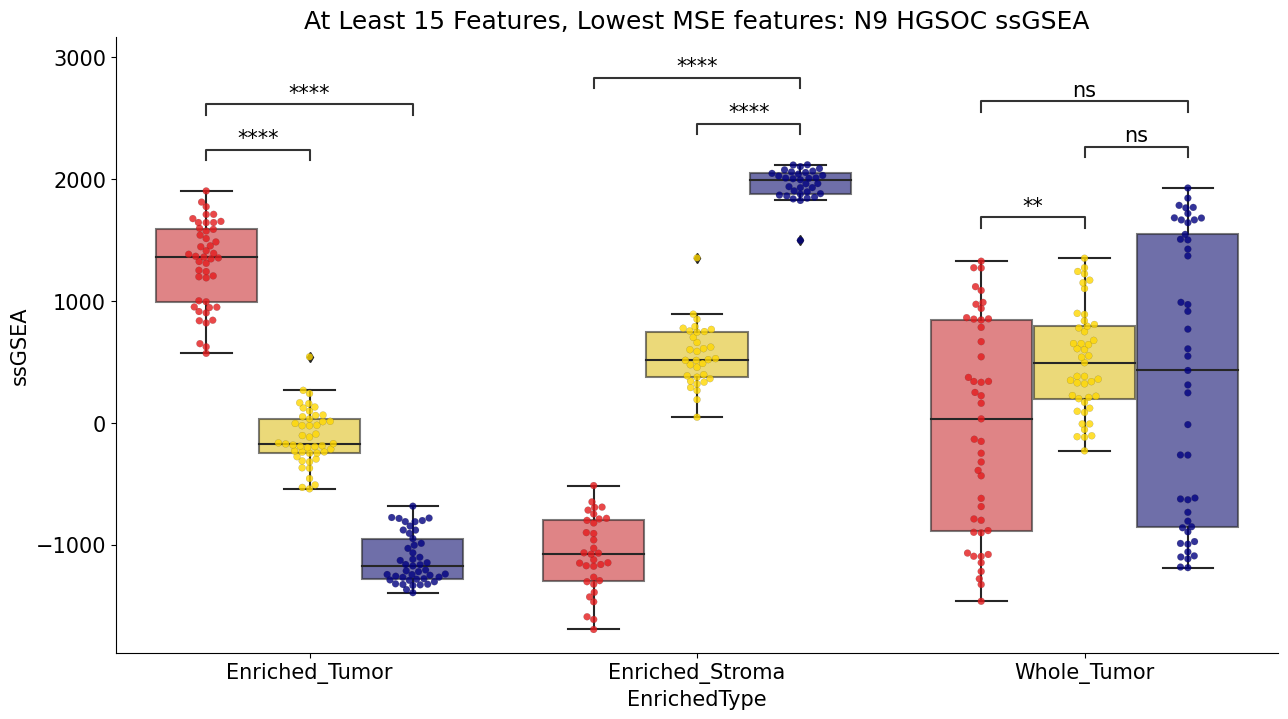

In [54]:
ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['EnrichedType'] = HGSOC_enriched_type['TissueType']

scaffold = pd.DataFrame(columns=ssGSEAt.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'ssGSEA'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = ssGSEAt[[x, 'EnrichedType', 'prediction']].rename(columns={x:'ssGSEA'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type} features: N9 HGSOC ssGSEA')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='lower left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

# remove legend, overlapping boxplot
legend = ax.legend()
legend.remove()

pairs = [
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Stroma')),
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Lymphocyte')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Tumor')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Lymphocyte')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Stroma')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Lymphocyte')),
    (('Whole_Tumor', 'Stroma'), ('Whole_Tumor', 'Lymphocyte'))
]
annot = Annotator(ax, pairs, data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

Lymphocyte - not in Enriched_Tumor v_counts... Putting count of 0
Stroma - not in Enriched_Tumor v_counts... Putting count of 0
Tumor - not in Enriched_Stroma v_counts... Putting count of 0
Lymphocyte - not in Enriched_Stroma v_counts... Putting count of 0


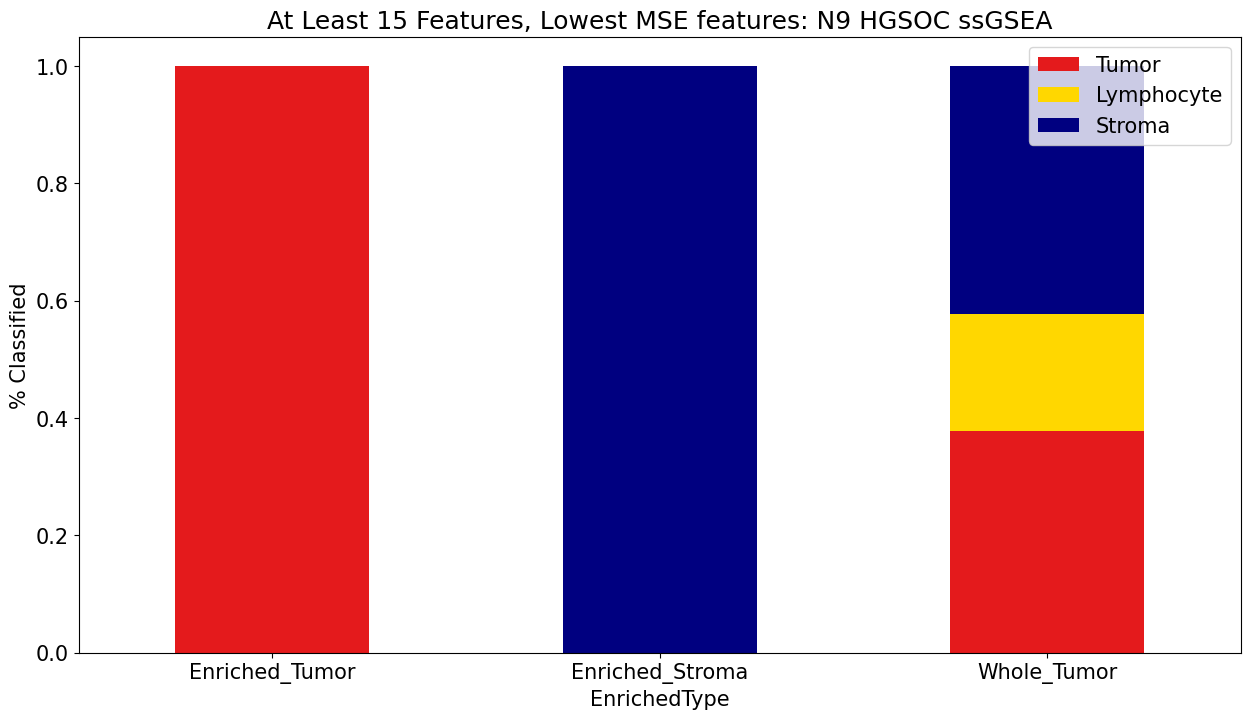

In [55]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in ssGSEAt.EnrichedType.unique():
    temp = ssGSEAt[ssGSEAt.EnrichedType == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'EnrichedType'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type} features: N9 HGSOC ssGSEA')
ax.set_xlabel('EnrichedType')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

# Get Gene Names
Currently, model_features_{model}.csv files have accession numbers, but make files that have their gene names.

In [56]:
for model in tls_strings:
    in_file_name = f'data/{model}/model_features_{model}.csv'
    in_data = pd.read_csv(in_file_name)

    out_file_name = f'{in_file_name.split(".")[0]}_gene_names.csv'
    # use admixture_tissue_annotation to get gene names from accession numbers
    genes = admixture_tissue_annotation.merge(in_data, how='right', left_index=True, right_on='0')['Gene']
    assert len(genes) == in_data.shape[0] # make sure the number of genes matches the number of accession numbers
    assert len(set(genes)) == len(genes) # see if there are any repeats (there shouldn't be)
    genes.to_csv(out_file_name) # save to csv

## Convert to HTML

In [58]:
!python -m nbconvert SVR_RFE.ipynb --to html

[NbConvertApp] Converting notebook full_process.ipynb to html
[NbConvertApp] Writing 2279774 bytes to full_process.html
